\begin{equation}
\left\{
\begin{array}{l}
\dot{S}_{1} = J_{0} - \frac{k_{1} S_{1} S_{6}}{1 + \left(\frac{S_{6}}{K_{1}}\right)^{q}}, \\
\dot{S}_{2} = 2 \frac{k_{1} S_{1} S_{6}}{1 + \left(\frac{S_{6}}{K_{1}}\right)^{q}} - k_{2} S_{2} (N - S_{5}) - k_{6} S_{2} S_{5}, \\
\dot{S}_{3} = k_{2} S_{2} (N - S_{5}) - k_{3} S_{3} (A - S_{6}), \\
\dot{S}_{4} = k_{3} S_{3} (A - S_{6}) - k_{4} S_{4} S_{5} - \kappa (S_{4} - S_{7}), \quad t \in [0, T], \\
\dot{S}_{5} = k_{2} S_{2} (N - S_{5}) - k_{4} S_{4} S_{5} - k_{6} S_{2} S_{5}, \\
\dot{S}_{6} = -2 \frac{k_{1} S_{1} S_{6}}{1 + \left(\frac{S_{6}}{K_{1}}\right)^{q}} + 2 k_{3} S_{3} (A - S_{6}) - k_{5} S_{6}, \\
\dot{S}_{7} = \psi \kappa (S_{4} - S_{7}) - k S_{7},
\end{array}
\right.
\end{equation}

### 原始代码  
BsplineKANLayer

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# from deepkan import SplineLinearLayer
from KAN import KANModel
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import nodepy.linear_multistep_method as lm
import torch.nn as nn
import torch.optim as optim
import timeit

torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数


# 超参数
n_steps = 10000          # 样本取点数     
steps = 5001             # 迭代次数
M = 1                    # 多步法的步数

# S1 = np.random.uniform(0.15,1.60,1)
# S2 = np.random.uniform(0.19,2.16,1)
# S3 = np.random.uniform(0.04,0.20,1)
# S4 = np.random.uniform(0.10,0.35,1)
# S5 = np.random.uniform(0.08,0.30,1)
# S6 = np.random.uniform(0.14,2.67,1)
# S7 = np.random.uniform(0.05,0.10,1)
# # initial condition
y0 = np.array([1.125,0.95,0.075,0.16,0.265,0.7,0.092]).flatten()


# 均匀取点
t_np = np.linspace(0, 10, num=n_steps)
dt = t_np[M] - t_np[0]   # 步长


# function that returns dx/dt
def f(x,t): # x is 3 x 1
    J0 = 2.5
    k1 = 100.0
    k2 = 6.0
    k3 = 16.0
    k4 = 100.0
    k5 = 1.28
    k6 = 12.0
    k = 1.8
    kappa = 13.0
    q = 4
    K1 = 0.52
    psi = 0.1
    N = 1.0
    A = 4.0
    
    f1 = J0 - (k1*x[0]*x[5])/(1 + (x[5]/K1)**q)
    f2 = 2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) - k2*x[1]*(N-x[4]) - k6*x[1]*x[4]
    f3 = k2*x[1]*(N-x[4]) - k3*x[2]*(A-x[5])
    f4 = k3*x[2]*(A-x[5]) - k4*x[3]*x[4] - kappa*(x[3]-x[6])
    f5 = k2*x[1]*(N-x[4]) - k4*x[3]*x[4] - k6*x[1]*x[4]
    f6 = -2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) + 2*k3*x[2]*(A-x[5]) - k5*x[5]
    f7 = psi*kappa*(x[3]-x[6]) - k*x[6]
    
    f = np.array([f1,f2,f3,f4,f5,f6,f7])
    return f

# 计算出微分方程的数值解，它使用 lsoda 方法进行数值积分，lsoda 方法使用了 Gear 公式的变步长、变阶数实现。它是一种隐式的多步法
y_np = odeint(f, y0, t_np) 

# # 计算微分方程的真实解
# y_np1 = source_fun_1(torch.from_numpy(t_np))
# y_np2= source_fun_2(torch.from_numpy(t_np))
# y_np = torch.stack([y_np1, y_np2], axis=1).numpy()
y_train = y_np[0::M,:]
y_train_new  = torch.tensor(y_train)
lamb = 0.1
model = KANModel(width=[7,15,15,7],grid_range=[-20,20])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.999),  eps=1e-32)
# optimizer = LBFGS(model.parameters(), lr=0.05, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

def net_Y(alpha,beta,T,y_train_new):
    Y = alpha[0] * T[:, M:, :] + dt * beta[0] * model(y_train_new[M:, :]).unsqueeze(0)
    for m in range(1, M + 1):
        Y = Y + alpha[m] * T[:, M-m:-m, :] + dt * beta[m] * model(y_train_new[M-m:-m, :]).unsqueeze(0) # S x (N-M+1) x D
    return Y

# 用于存储每次迭代的损失值
Train_loss_list = []
iteration_list = []

start_time = timeit.default_timer()
for epoch in range(steps):
    model.train()
    scheme = 'AM'
        # Load weights
    switch = {'AM': lm.Adams_Moulton,
                'AB': lm.Adams_Bashforth,
                'BDF': lm.backward_difference_formula}
    method = switch[scheme](M)
    # 将 method.alpha 和 method.beta 转换为浮点数数组
    alpha = torch.tensor(-np.array(method.alpha[::-1], dtype=np.float32))
    beta = torch.tensor(np.array(method.beta[::-1], dtype=np.float32))
    T = y_train_new.unsqueeze(0)
    optimizer.zero_grad()
    Y_pred = net_Y(alpha,beta,T,y_train_new)
    loss = criterion(Y_pred, torch.zeros_like(Y_pred))
    l2loss = criterion(Y_pred, torch.zeros_like(Y_pred))  + lamb * model.reg(y_train_new)
    l2loss.backward()
    optimizer.step()


    # 存储损失值和迭代次数
    Train_loss_list.append(loss.cpu().detach().numpy())
    iteration_list.append(epoch)



    if epoch % 500 == 0:
        print(f'Epoch {epoch+1}/{steps}, Train_loss: {loss.item(): .4e}')

elapsed = timeit.default_timer() - start_time
print(f"Time: {elapsed:.4f}")

Epoch 1/5001, Train_loss:  1.2814e-05
Epoch 501/5001, Train_loss:  1.0225e-05
Epoch 1001/5001, Train_loss:  2.2035e-06
Epoch 1501/5001, Train_loss:  9.3020e-07
Epoch 2001/5001, Train_loss:  1.4047e-07
Epoch 2501/5001, Train_loss:  3.8436e-08
Epoch 3001/5001, Train_loss:  1.8688e-08
Epoch 3501/5001, Train_loss:  1.1288e-08
Epoch 4001/5001, Train_loss:  7.3448e-09
Epoch 4501/5001, Train_loss:  5.2131e-09
Epoch 5001/5001, Train_loss:  3.8276e-09
Time: 11130.4957


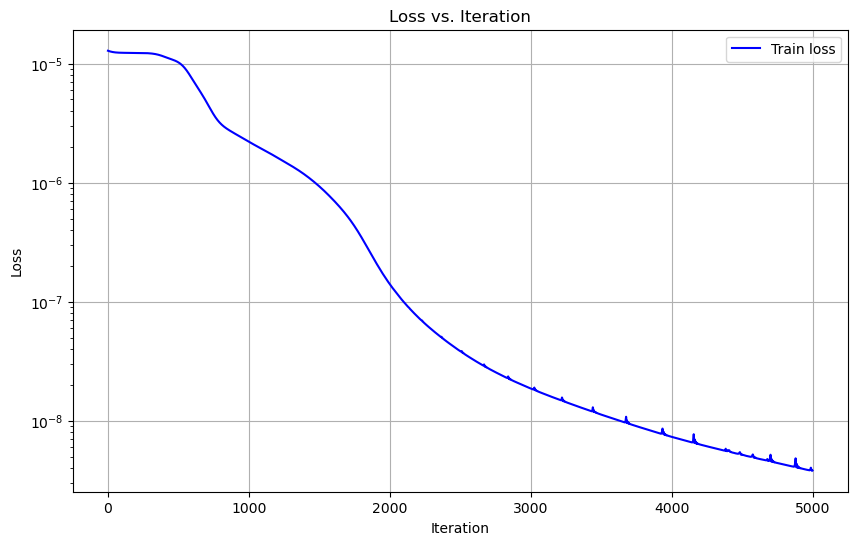

In [2]:
# Ploting
plt.figure(figsize=(10, 6))
plt.plot(iteration_list, Train_loss_list, label='Train loss', color='b')  # 绘制训练损失曲线，蓝色
plt.yscale('log')
# plt.ylim(10e-15, 10e1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig('Cubic2D_Error_10-6.png', format='png', dpi=600)

In [3]:
test_steps = n_steps
test_np = np.linspace(0, 20, test_steps)
test_np_new = torch.linspace(0, 20, test_steps)

def predict_f(y_star):
    y_star_tensor = torch.tensor(y_star)
    with torch.no_grad():
        F_star = model(y_star_tensor)
    return F_star.numpy()


def learned_f(x,t):
    f = predict_f(x[None,:])
    return f.flatten()

learned_X_star = odeint(learned_f, y0, test_np)    
y_np1 = odeint(f, y0, test_np)

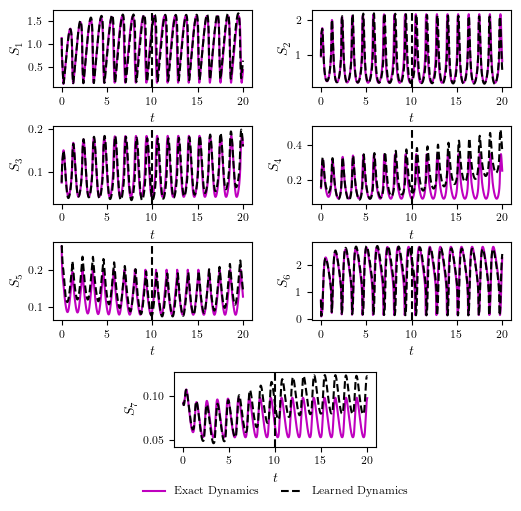

In [4]:
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
####### Plotting ##################

fig, ax = newfig(1.0, 1.55)
ax.axis('off')

gs0 = gridspec.GridSpec(3, 2)
gs0.update(top=0.95, bottom=0.35, left=0.1, right=0.95, hspace=0.5, wspace=0.3)

ax = plt.subplot(gs0[0:1, 0:1])
ax.plot(test_np,y_np1[:,0],'m-')
ax.plot(test_np,learned_X_star[:,0],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_1$')
ax.axvline(x=10, color='k', linestyle='--')

ax = plt.subplot(gs0[0:1, 1:2])
ax.plot(test_np,y_np1[:,1],'m-')
ax.plot(test_np,learned_X_star[:,1],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_2$')
ax.axvline(x=10, color='k', linestyle='--')

ax = plt.subplot(gs0[1:2, 0:1])
ax.plot(test_np,y_np1[:,2],'m-')
ax.plot(test_np,learned_X_star[:,2],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_3$')
ax.axvline(x=10, color='k', linestyle='--')

ax = plt.subplot(gs0[1:2, 1:2])
ax.plot(test_np,y_np1[:,3],'m-')
ax.plot(test_np,learned_X_star[:,3],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_4$')
ax.axvline(x=10, color='k', linestyle='--')

ax = plt.subplot(gs0[2:3, 0:1])
ax.plot(test_np,y_np1[:,4],'m-')
ax.plot(test_np,learned_X_star[:,4],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_5$')
ax.axvline(x=10, color='k', linestyle='--')

ax = plt.subplot(gs0[2:3, 1:2])
ax.plot(test_np,y_np1[:,5],'m-')
ax.plot(test_np,learned_X_star[:,5],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_6$')
ax.axvline(x=10, color='k', linestyle='--')

gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.25, bottom=0.105, left=0.325, right=0.7, hspace=0.5, wspace=0.3)

ax = plt.subplot(gs1[0:1, 0:2])
ax.plot(test_np,y_np1[:,6],'m-',label='Exact Dynamics')
ax.plot(test_np,learned_X_star[:,6],'k--',label='Learned Dynamics')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_7$')
ax.axvline(x=10, color='k', linestyle='--')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2, frameon=False)

# plt.savefig('Glycolytic_Error.png', format='png', dpi=600)
# savefig('./figures/Glycolytic', crop = False)